In [1]:
# Import liberaries and functions
import pandas as pd
import numpy as np
from scipy import stats

import gc

In [2]:
topics_df = pd.read_csv("Data/RF_text_attr.csv", parse_dates=['report_dt', 'filing_dt'], index_col=0)

companies = pd.read_csv('Data/all_companies.csv')

topics_df = pd.merge(left=topics_df, right=companies[["SIC", "FF"]].drop_duplicates(), on="SIC", how='left')
topics_df["FF"] = topics_df["FF"].fillna(48).astype(int)

# Replace missing FOG scores with 1 (are those with less than 100 words)
topics_df.fillna({'FOG': 1}, inplace=True)

In [5]:
# Use historical SIC data (from Cumpustat) for industry analysis
sich = pd.read_csv(
    filepath_or_buffer="Data\Financials.csv",
    parse_dates=['datadate'],
    usecols=['cik', 'datadate', 'sich']
).drop_duplicates()

sich.sort_values(['cik', 'datadate'], inplace=True)
sich["datadate"] = pd.to_datetime(sich["datadate"], format="%d/%m/%Y")

topics_df = pd.merge(
    left=topics_df,
    right=sich[[
        'cik', 'datadate', 'sich']],
    left_on=["CIK", "report_dt"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate', 'cik'])

topics_df['sich'] = topics_df['sich'].fillna(topics_df['SIC']).astype(int)

In [6]:
# First 2 digits of SIC -> Major sector group
topics_df['SIC2'] = topics_df['sich'].map(lambda x: f"{int(x):04d}"[:2])

topics_df['SIC3'] = topics_df['sich'].map(lambda x: f"{int(x):04d}"[:3])

### Firm level

In [7]:
# Risk topics disclosed and not disclosed per report 
disc_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt", "FF", "sich"], 
    columns='Topic_H', values='Score'
).notna().astype(int).reset_index()

# Long format
disc_long = pd.melt(disc_df, id_vars=["CIK", "filing_dt", "report_dt", "FF", "sich"], value_name='Disclosed')
disc_long.sort_values(["CIK", 'Topic_H', "filing_dt", "report_dt"], inplace=True)

disc_long['DiscSum'] = disc_long.groupby(["CIK", 'Topic_H'])['Disclosed'].cumsum()

# Total number of risk topics
disc_long['TotalRFs'] = disc_long.groupby(["CIK", "filing_dt", "report_dt"])['Disclosed'].transform('sum')

In [8]:
# Difference between disclosed risk topics in 2 consecutive years
disc_diff = disc_df.filter(range(0,100)) - disc_df.groupby("CIK")[disc_df.filter(range(0,100)).columns].shift(1)

# Repeated risk factors
disc_repeat = (
    disc_df.filter(range(0,100))
    + disc_df.groupby("CIK")[disc_df.filter(range(0,100)).columns].shift(1) 
    == 2
).astype(int)

# Generate added, repeated and removed dummies
disc_long['Added'] = (pd.melt(disc_diff)['value']>0).astype(int)
disc_long['Removed'] = (pd.melt(disc_diff)['value']<0).astype(int)
disc_long['Repeated'] = pd.melt(disc_repeat)['value']

# Whether risk factor was disclosed in the previouse year's report
disc_long['LstYrDisc'] = disc_long.sort_values(by=['CIK', 'Topic_H', 'filing_dt']).groupby(['CIK', 'Topic_H'])['Disclosed'].shift(1)

In [9]:
# Keep RFs that if disclosed, they are either added or repeated
disc_long = (
    disc_long[disc_long[['Added', 'Repeated']]
              .sum(axis=1)==disc_long['Disclosed']]
              .reset_index(drop=True)
)

# Number of days from fiscal year end and actual filing date
disc_long['rfGap'] = (disc_long['filing_dt'] - disc_long['report_dt']).dt.days

disc_long['fyear'] = disc_long["filing_dt"].dt.year
disc_long['ryear'] = disc_long["report_dt"].dt.year

In [10]:
# Change in the repeated disclosed risk topics per report 
disc_change_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt"], 
    columns='Topic_H', values='Score',
).reset_index()

# Long format
disc_change_long = pd.melt(
    disc_change_df, id_vars=["CIK", "filing_dt", "report_dt"], value_name='Score'
).dropna()

disc_change_long['D_Score'] = disc_change_long['Score'] - disc_change_long.groupby(["CIK", "Topic_H"])['Score'].shift(1)

In [11]:
disc_long = pd.merge(
    left=disc_long,
    right=disc_change_long,
    on=['CIK', 'filing_dt', 'report_dt', 'Topic_H'],
    how='left'
)

disc_long.fillna({'D_Score': 0}, inplace=True)

In [12]:
# Length of disclosed RFs as the total number of words 
length_df = pd.pivot_table(
    topics_df, index = ["CIK", "filing_dt", "report_dt"], 
    columns='Topic_H', values='rprt_length', aggfunc='sum',
    fill_value=0 # NA length means not disclosed so equal to 0
).reset_index()

# Long format
length_long = pd.melt(length_df, id_vars=["CIK", "filing_dt", "report_dt"], value_name='RF_length')
length_long.sort_values(["CIK", "Topic_H", "filing_dt", "report_dt"], inplace=True)

# Change of the length of the topics over the year
length_long['D_length'] = length_long['RF_length'] - length_long.groupby(["CIK", "Topic_H"])['RF_length'].shift(1)

In [13]:
disc_long = pd.merge(
    left=disc_long,
    right=length_long,
    on=['CIK', 'filing_dt', 'report_dt', 'Topic_H'],
    how='left'
)

In [14]:
# Aggregate text attributes at the CIK-year-Topic level
txt_attr = (
    topics_df.groupby(["CIK", "report_dt", "filing_dt", "Topic_H"])[
        ['Pa', 'Pr', 'Fu', 'Sentiment', 'FOG']
    ]
    .agg({
        'Pa': 'sum',
        'Pr': 'sum', 
        'Fu': 'sum',
        'Sentiment': 'mean',
        'FOG': 'mean',
    }).reset_index()
).sort_values(["CIK", "report_dt", "filing_dt", "Topic_H"])

disc_long = pd.merge(
    left=disc_long,
    right=txt_attr,
    on=['CIK', 'filing_dt', 'report_dt', 'Topic_H'],
    how='left'
)

disc_long.fillna(
    {'Pa':0, 'Pr':0, 'Fu':0, 'Sentiment':0, 'FOG':0}, 
    inplace=True
)

In [15]:
# SIC code of high-tech and regulated industries (Kothari, 2009)
high_tech = []
high_tech.extend(range(2833, 2837))
high_tech.extend(range(3570, 3578))
high_tech.extend(range(3600, 3675))
high_tech.extend(range(7371, 7380))
high_tech.extend(range(8731, 8735))

regulated = [4812, 4813, 4833, 4841, 4922, 4923, 4924, 4931, 4941]
regulated.extend(range(4811, 4900))

disc_long['high_tech'] = disc_long['sich'].isin(high_tech).astype(int)
disc_long['regulated'] = disc_long['sich'].isin(regulated).astype(int)

# Some industries that are believed to have higher litigation risk
# https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Fjels.12115&file=jels12115-sup-0001-suppinfo.pdf
# Biotech (SIC codes 2833–2836), computer Hardware (SIC codes 3570–3577), computer 
# Software (SIC codes 7371–7379), Retail (SIC codes 5200–5961), and Electronics (SIC codes 
# 3600–3674)

### Industry level

In [ ]:
# Counting the actual number of firms per industry (using all-submissions from EDGAR)
filings_df = pd.read_csv("Data/filings_df.csv", parse_dates=["filingDate", "reportDate"])

filings_df.dropna(subset=["filingDate", "reportDate", "sic"], inplace=True)

filings_df = filings_df.sort_values(['cik', 'reportDate', 'filingDate']).drop_duplicates(keep='last')

# Add historical SIC
filings_df = pd.merge(
    left=filings_df,
    right=sich[[
        'cik', 'datadate', 'sich']],
    left_on=["cik", "reportDate"],
    right_on=["cik", "datadate"],
    how="left"
).drop(columns=['datadate'])

filings_df['sich'] = filings_df['sich'].fillna(filings_df['sic']).astype(int)

# Add Fama-French industry
filings_df = pd.merge(
    left=filings_df, right=companies[["SIC", "FF"]].drop_duplicates(), 
    left_on="sich", right_on="SIC", how='left'
).drop(columns="SIC")

filings_df["FF"] = filings_df["FF"].fillna(48).astype(int)

In [ ]:
filings_df = filings_df[
    (filings_df["filingDate"] >= disc_df['filing_dt'].min())
    &(filings_df["filingDate"] <= disc_df['filing_dt'].max())
]
filings_df['fyear'] = filings_df["filingDate"].dt.year

# Number of reporting firms per year per industry
cnt_firms = filings_df.groupby(['FF', 'fyear'])['filingDate'].nunique().reset_index()

In [ ]:
# Number of firms in the industry
disc_long['#firms'] = pd.merge(
    left=disc_long,
    right=cnt_firms,
    on=['FF', 'fyear'],
    how='left'
)['filingDate']

In [22]:
disc_df["filing_dt-1"] = disc_df["filing_dt"] - pd.Timedelta(weeks=52)

def count_func(x):
    """
    Counts the number of firms in the industry that disclose a specific RF.
    """
    df_slice = disc_df[
        (disc_df["filing_dt"]>x["filing_dt-1"])
        &(disc_df["filing_dt"]<=x["filing_dt"])
        &(disc_df['FF']==x['FF'])
    ]
    output = (
        df_slice[df_slice['CIK']!=x['CIK']].filter(range(95)).sum() / df_slice["filing_dt"].count()
    )
    
    return output

# Running the function on disc_df
IndDisc_df = disc_df.drop(columns=range(95)).copy()
IndDisc_df.loc[:, range(95)] = disc_df.apply(count_func, axis=1)
IndDisc_df.drop(columns=['filing_dt-1'], inplace=True)


# Create the data in long format
Inddisc_long = pd.melt(IndDisc_df, id_vars=["CIK", "filing_dt", "report_dt", "FF"], value_name='IndDisc')

In [23]:
# Drop RFs that have never been disclosed per industry 
Inddisc_long = Inddisc_long[Inddisc_long.groupby(['FF', 'Topic_H'])['IndDisc'].transform('sum')>0]

In [24]:
def other_count_func(x):
    """
    Disclosing firms not in the firm's industry.
    """
    df_slice = disc_df[
        (disc_df["filing_dt"]>x["filing_dt-1"])&
        (disc_df["filing_dt"]<=x["filing_dt"])&
        (disc_df['FF']!=x['FF'])
    ]
    output = (
        df_slice.filter(range(95)).sum() / df_slice["filing_dt"].count()
    )
    
    return output

# Running the function on disc_df
OthrIndDisc_df = disc_df.drop(columns=range(95)).copy()
OthrIndDisc_df.loc[:, range(95)] = disc_df.apply(other_count_func, axis=1)
OthrIndDisc_df.drop(columns=['filing_dt-1'], inplace=True)

# Create the data in long format
OthrIndDisc_long = pd.melt(OthrIndDisc_df, id_vars=["CIK", "filing_dt", "report_dt", "FF"], value_name='OtherIndDisc')

In [25]:
disc_long['IndDisc'] = pd.merge(
    left=disc_long,
    right=Inddisc_long,
    on=["CIK", "filing_dt", "report_dt", "Topic_H"],
    how='left'
)['IndDisc'] * 100

disc_long['OtherIndDisc'] = pd.merge(
    left=disc_long,
    right=OthrIndDisc_long,
    on=["CIK", "filing_dt", "report_dt", "Topic_H"],
    how='left'
)['OtherIndDisc'] * 100

In [26]:
# Drop the first year of every firm observation
disc_long.dropna(subset=['LstYrDisc'], inplace=True)

disc_long.dropna(subset=['IndDisc'], inplace=True)

In [27]:
disc_long.reset_index(drop=True, inplace=True)

Industry specific

In [19]:
def ttest_func(x):
    A = x['IndDisc'].values
    B = x['OtherIndDisc'].values

    tstat = stats.ttest_ind(a=A, b=B, equal_var=False).statistic
    pvalue = stats.ttest_ind(a=A, b=B, equal_var=False).pvalue

    return (tstat, pvalue)

In [ ]:
ttest_df = disc_long.groupby(['FF', 'Topic_H'])[['IndDisc', 'OtherIndDisc']].mean()

ttest = disc_long.groupby(['FF', 'Topic_H'])[['IndDisc', 'OtherIndDisc']].apply(ttest_func)

ttest_df['tstat'] = ttest.apply(lambda x: x[0]).values
ttest_df['pvalue'] = ttest.apply(lambda x: x[1]).values

# IndDisc > NoIndDisc statistically significant at 5%
ttest_df['IndSpecific'] = ((ttest_df['pvalue']<0.05)&(ttest_df['IndDisc']>ttest_df['OtherIndDisc'])).astype(int)

In [ ]:
disc_long.loc[:, 'IndSpecific'] = pd.merge(
    left=disc_long,
    right=ttest_df,
    how='left',
    left_on=['FF', 'Topic_H'],
    right_index=True
)['IndSpecific'].values

In [ ]:
# Industry disclosure quartiles
disc_long.loc[:, 'Qcut'] = disc_long\
    .groupby('Topic_H')['IndDisc']\
        .transform(lambda x: pd.cut(x, 4, labels=False)).astype(int) + 1

## DVs

### Volatility and BA Spread

In [27]:
prices_df = pd.read_csv("Data\Prices.csv", parse_dates=['Date'])
prices_df.sort_values(["Instrument", "Date"], inplace=True)
prices_df.rename(columns={"Instrument": "CIK", "Date": "filing_dt"}, inplace=True)
prices_df = prices_df[prices_df["filing_dt"]>'2005-01-01'].set_index('filing_dt')
prices_df.columns

Index(['CIK', 'CLOSEPRICE', 'VOLUME', 'COMPANYMARKETCAP', 'TTLCMNSHARESOUT'], dtype='object')

In [28]:
# Daily shares turnover
prices_df["SHRTURN"] = prices_df["VOLUME"] / prices_df["TTLCMNSHARESOUT"]

# Returns
# prices_df["Return"] = prices_df.groupby("CIK")["CLOSEPRICE"].pct_change(1)

prices_df.loc[:, "CLOSEPRICE"] = prices_df.groupby("CIK")["CLOSEPRICE"].ffill(limit=1)
prices_df["Return"] = prices_df.groupby("CIK")["CLOSEPRICE"].pct_change(1, fill_method=None)

In [29]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [prices_df.reset_index()[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

prices_df.reset_index(inplace=True)
prices_df = pd.merge(left=CIKdates, right=prices_df, on=["CIK", "filing_dt"], how='left')
prices_df.set_index('filing_dt', inplace=True)

In [30]:
# Time window
N = 30

# Average of N-day std of daily returns
std_returns = (
    prices_df.groupby("CIK")["Return"]
    .rolling(N, min_periods=N//2).std().to_frame()
)
# Window [2, 32]
std_returns[f"Volatility+{N}"] = std_returns.groupby("CIK")["Return"].shift(-N-2)
# Window [-32, -2]
std_returns[f"Volatility_{N}"] = std_returns.groupby("CIK")["Return"].shift(2)

# Window [-5, 60]
std_returns[f"Volatility+60"] = prices_df.groupby("CIK")["Return"].rolling(65, min_periods=30).std().groupby("CIK").shift(-60)

# Average of 120-day std of daily returns
std_returns[f"Volatility_120"] = prices_df.groupby("CIK")["Return"].rolling(120, min_periods=60).std()

std_returns.drop(columns="Return", inplace=True)

In [31]:
# Average of N-day trade volumes during event
N=10
MA_vol = prices_df.groupby("CIK")["SHRTURN"].rolling(N, min_periods=6).mean().to_frame()
MA_vol[f"SHRTURN"] = MA_vol.groupby("CIK")["SHRTURN"].shift(N//2)

# Window [2, 7]
MA_vol["SHRTURN+5"] = prices_df.groupby("CIK")["SHRTURN"].rolling(5, min_periods=3).mean().shift(-7)
# Window [-7, -2]
MA_vol["SHRTURN_5"] = prices_df.groupby("CIK")["SHRTURN"].rolling(5, min_periods=3).mean().shift(2)

In [32]:
BidAsk_df = pd.read_csv("Data\BidAsk.csv",  parse_dates=['Date']).drop_duplicates()
BidAsk_df.sort_values(["Instrument", "Date"], inplace=True)
BidAsk_df.rename(columns={"Instrument": "CIK", "Date": "filing_dt"}, inplace=True)
BidAsk_df = BidAsk_df[BidAsk_df["filing_dt"]>'2005-01-01']
BidAsk_df.columns

Index(['CIK', 'HIGHPRICE', 'LOWPRICE', 'BIDPRICE', 'ASKPRICE', 'filing_dt'], dtype='object')

In [33]:
BidAsk_df = pd.merge(
    left=BidAsk_df, 
    right=prices_df.reset_index()[['CIK', 'filing_dt', 'CLOSEPRICE']], 
    on=['CIK', 'filing_dt'],
    how='left'
)

In [34]:
BidAsk_df["BAspread"] = (BidAsk_df["ASKPRICE"] - BidAsk_df['BIDPRICE'])/BidAsk_df["CLOSEPRICE"]

BidAsk_df = pd.merge(left=CIKdates, right=BidAsk_df, on=["CIK", "filing_dt"], how='left')
BidAsk_df.set_index('filing_dt', inplace=True)

In [35]:
N = 30

# N-day moving average (trading days only)
MA_BA = BidAsk_df.groupby('CIK')['BAspread'].rolling(N, min_periods=N//2).mean().to_frame()
# Window [2, 32]
MA_BA[f"Spread+{N}"] = MA_BA.groupby("CIK")["BAspread"].shift(-N-2)
# Window [-32, -2]
MA_BA[f"Spread_{N}"] = MA_BA.groupby("CIK")["BAspread"].shift(2)

# Window [-5, 60]
MA_BA["Spread+60"] = BidAsk_df.groupby('CIK')['BAspread'].rolling(65, min_periods=30).mean().groupby("CIK").shift(-60)

# Average of 120-day bid-ask spread
MA_BA[f"Spread_120"] = BidAsk_df.groupby('CIK')['BAspread'].rolling(120, min_periods=60).mean()

MA_BA.drop(columns='BAspread', inplace=True)

In [36]:
IVol = pd.read_csv("Data\WRDS_Beta.csv", 
                   usecols=['PERMNO', 'DATE', 'n', 'b_mkt', 'ivol', 'TICKER'], 
                   parse_dates=['DATE'])

In [37]:
CIK_PERMNO_TIC = pd.read_csv("Data\CIK_PERMNO_TIC.csv")

IVol = pd.merge(
    left=IVol,
    right=CIK_PERMNO_TIC[['PERMNO', 'cik']],
    on='PERMNO',
    how='left'
)

IVol['cik2'] = pd.merge(
    left=IVol,
    right=CIK_PERMNO_TIC[['tic', 'cik']],
    left_on='TICKER',
    right_on='tic',
    how='left'
)['cik_y']

IVol.fillna({'cik': IVol['cik2']}, inplace=True)

In [38]:
IVol = IVol.drop(columns=['cik2']).dropna(subset=['cik', 'DATE'])

IVol[['cik']] = IVol[['cik']].astype(int)
IVol.rename(columns={"cik": "CIK", "DATE": "filing_dt"}, inplace=True)
IVol = IVol.sort_values(by=["CIK", "filing_dt"]).reset_index(drop=True)

In [39]:
IVol['ivol'] = IVol['ivol'].str.replace('%', '').astype(float)
IVol["Fwrd_ivol"] = IVol.groupby("CIK")["ivol"].shift(-60)

In [40]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [IVol[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

IVol = pd.merge(left=CIKdates, right=IVol, on=["CIK", "filing_dt"], how='left')

IVol[['b_mkt', 'ivol', 'Fwrd_ivol']] = IVol.groupby('CIK')[['b_mkt', 'ivol', 'Fwrd_ivol']].ffill(limit=3)

IVol.drop(columns=['PERMNO', 'n', 'TICKER'], inplace=True)

### Earnings Estimates

In [31]:
EPSEst = pd.read_csv("Data\EIKON_EPSforecast.csv", parse_dates=['TR.EPSESTVALUE().DATE', 'TR.EPSESTVALUE().periodenddate'])
EPSAct = pd.read_csv("Data\EIKON_EPSActual.csv", parse_dates=['Date', 'Report Date', 'Period End Date'])


In [ ]:

EPSEst = pd.merge(
    left=EPSEst,
    right=EPSAct.drop(columns=['Date']),
    on=['Instrument', 'Period End Date'],
    how='left'
)

# Absolute diff actual and estimated earings
EPSEst["Act-Est"] = (EPSEst['Earnings Per Share - Actual'] - EPSEst['Earnings Per Share - Broker Estimate'])

EPSEst = EPSEst.sort_values(['Instrument', 'Period End Date', 'Date']).reset_index(drop=True)

In [34]:
# Last fiscal year end
FYEnd = EPSEst[['Instrument', 'TR.EPSESTVALUE().periodenddate']].drop_duplicates().reset_index(drop=True)
FYEnd['FYEnd-1'] = (
    FYEnd.groupby(['Instrument'])['TR.EPSESTVALUE().periodenddate'].shift(1)
)

EPSEst = pd.merge(
    left=EPSEst,
    right=FYEnd,
    on=['Instrument', 'TR.EPSESTVALUE().periodenddate'],
    how='left'
).dropna(subset=['FYEnd-1'])

EPSEst["FY-1"] = EPSEst['FYEnd-1'].dt.year

In [35]:
# Risk disclosure dates
disc_dts = disc_df[["CIK", "filing_dt", "report_dt"]].copy()
disc_dts['FY-1'] = disc_dts['report_dt'].dt.year
disc_dts.drop_duplicates(subset=['CIK', 'FY-1'], inplace=True)

# Match estimation errors with filing date
EPSEst = pd.merge(
    left=EPSEst,
    right=disc_dts,
    left_on=['Instrument', 'FY-1'],
    right_on=["CIK", 'FY-1'],
    how='left'
).dropna(subset=['CIK'])

EPSEst['CIK'] = EPSEst['CIK'].astype(int)

In [40]:
# Estimates after filing date of last annual report
EPSEst['After'] = (
    (EPSEst['TR.EPSESTVALUE().DATE'].dt.date >= EPSEst['filing_dt']-pd.Timedelta(weeks=1))
    & (EPSEst['TR.EPSESTVALUE().DATE'].dt.date < EPSEst['filing_dt']+pd.Timedelta(days=90))
).astype(int)

In [43]:
EPSEst#[EPSEst['After']==1]

,Instrument,TR.EPSESTVALUE().DATE,TR.EPSESTVALUE().periodenddate,TR.EPSESTVALUE().analystcode,TR.EPSESTVALUE(),FYEnd-1,FY-1,CIK,filing_dt,report_dt,After
0,1750,2007-03-22 11:28:00+00:00,2007-05-31,11ZW,1.39895,2006-05-31,2006,1750,2006-07-17,2006-05-31,0
1,1750,2007-03-22 16:15:00+00:00,2007-05-31,4CAH,1.40894,2006-05-31,2006,1750,2006-07-17,2006-05-31,0
2,1750,2007-03-27 08:28:00+00:00,2007-05-31,51BZ,1.39895,2006-05-31,2006,1750,2006-07-17,2006-05-31,0
3,1750,2007-03-30 08:04:00+00:00,2007-05-31,3XVH,1.38896,2006-05-31,2006,1750,2006-07-17,2006-05-31,0
4,1750,2007-04-12 07:12:00+00:00,2007-05-31,3QFZ,1.39895,2006-05-31,2006,1750,2006-07-17,2006-05-31,0
...,...,...,...,...,...,...,...,...,...,...,...
448364,1868941,2022-08-18 08:36:00+00:00,2022-09-30,6W9F,-1.56400,2021-09-30,2021,1868941,2021-12-14,2021-09-30,0
448365,1868941,2022-08-18 11:51:00+00:00,2022-09-30,88UJ,-1.67000,2021-09-30,2021,1868941,2021-12-14,2021-09-30,0
448366,1868941,2022-09-01 19:09:00+00:00,2022-09-30,NaN,-1.19000,2021-09-30,2021,1868941,2021-12-14,2021-09-30,0
448367,1868941,2022-09-13 08:40:00+00:00,2022-09-30,8H7M,-1.97000,2021-09-30,2021,1868941,2021-12-14,2021-09-30,0


In [ ]:

# Standasrd deviation fo analyst forecasts and Analyst forecast errors after filing date
EPSEst_After = (
    EPSEst[EPSEst['After']==1]
    .groupby(['CIK', 'FY-1'])[['Earnings Per Share - Broker Estimate', 'Earnings Per Share - Actual', 'Act-Est']]
    .agg({'Earnings Per Share - Broker Estimate': 'std', 'Act-Est': 'mean', 'Earnings Per Share - Actual': 'mean'})
)
EPSEst_After['nEsts'] = EPSEst[EPSEst['After']==1].groupby(['CIK', 'FY-1'])['Analyst Code'].nunique()
EPSEst_After.rename(columns={'Earnings Per Share - Broker Estimate': 'EPSEst'}, inplace=True)

EPSEst_After.reset_index(inplace=True)

EPSEst['Before'] = (
    (EPSEst['Date'] < EPSEst['filing_dt']-pd.Timedelta(weeks=1))
    & (EPSEst['Date'] >= EPSEst['filing_dt']-pd.Timedelta(days=90))
).astype(int)


# Standasrd deviation fo analyst forecasts and Analyst forecast errors Before filing date
EPSEst_Before = (
    EPSEst[EPSEst['Before']==1]
    .groupby(['CIK', 'FY-1'])[['Earnings Per Share - Broker Estimate', 'Act-Est']]
    .agg({'Earnings Per Share - Broker Estimate': 'std', 'Act-Est': 'mean'})
)

EPSEst_Before.rename(columns={'Earnings Per Share - Broker Estimate': 'EPSEst'}, inplace=True)

EPSEst_Before.reset_index(inplace=True)

In [45]:
EPSEst_After = pd.merge(
    left=EPSEst_After,
    right=EPSEst_Before,
    on=['CIK', 'FY-1'],
    how='outer',
    suffixes=['', '_before']
)

## Control variables

In [46]:
Beta = pd.read_csv("Data\Beta_AR.csv", parse_dates=['Date'])
Beta.drop_duplicates(inplace=True)
Beta.columns

Index(['Date', 'Instrument', 'Beta_90', 'Beta_120', 'Beta_250', 'AR', 'CAR_5',
       'CAR_10', 'CAR_2'],
      dtype='object')

In [47]:
Beta.rename(columns={"Instrument": "CIK", "Date": "filing_dt"}, inplace=True)
Beta = pd.merge(left=CIKdates, right=Beta, on=["CIK", "filing_dt"], how='left')
Beta.set_index('filing_dt', inplace=True)

In [48]:
# Daily Beta
Beta["BETA+120"] = Beta.groupby('CIK')["Beta_120"].shift(-120)
Beta["BETA+90"] = Beta.groupby('CIK')["Beta_90"].shift(-90)

In [49]:
Analysts = pd.read_csv("Data\Analysts.csv")
Analysts.dropna(inplace=True)

Analysts.columns = ['Instrument', 'NUMBEROFANALYSTS', 'Date']
Analysts['Date'] = pd.to_datetime(Analysts['Date'], errors='coerce').dt.tz_localize(None)

In [50]:
Analyst_df = pd.merge(
    left=prices_df.reset_index()[["filing_dt", "CIK"]], 
    right=Analysts, 
    left_on=["filing_dt", "CIK"],
    right_on=["Date", "Instrument"],
    how="outer"
).drop(columns=["Date", "Instrument"])

Analyst_df = Analyst_df[(Analyst_df["filing_dt"]>'2005-01-01')&(Analyst_df["filing_dt"]<'2023-01-01')]

Analyst_df.sort_values(['CIK', 'filing_dt', 'NUMBEROFANALYSTS'], inplace=True)

In [51]:
Analyst_df["NUMBEROFANALYSTS"] = Analyst_df.groupby("CIK")["NUMBEROFANALYSTS"].ffill()
Analyst_df.drop_duplicates(subset=["filing_dt", "CIK"], keep='last', inplace=True)
Analyst_df.fillna(0, inplace=True)

In [52]:
FF_rtrn = pd.read_csv("48_Industry_Portfolios_daily_CSV/IndustryDaily.csv")
FF_rtrn["Date"] = pd.to_datetime(FF_rtrn["Date"], format="%Y%m%d")
FF_rtrn = FF_rtrn[FF_rtrn["Date"]>="2004-01-01"].set_index("Date")

In [53]:
FF_vol = FF_rtrn.rolling(120).std().dropna().unstack().reset_index()
FF_vol.rename(columns={"level_0": "FF", "level_1": "Date", 0: "IndVol_"}, inplace=True)
FF_vol["FF"] = FF_vol["FF"].astype(int)

FF_vol["IndVol+"] = FF_vol.groupby("FF")['IndVol_'].shift(-120)

In [54]:
FreeFloat = pd.read_csv("Data/FreeFloat.csv")

FreeFloat.dropna(inplace=True)

FreeFloat.columns = ['CIK', 'filing_dt', 'FREEFLOAT']
FreeFloat['filing_dt'] = pd.to_datetime(FreeFloat['filing_dt'], errors='coerce').dt.tz_localize(None)

FreeFloat['CIK'] = FreeFloat['CIK'].astype(int)

FreeFloat.sort_values(by=['CIK', 'filing_dt'], inplace=True)

In [55]:
# Combine the list of CIKs and filing date in main dataframe and prices df
CIKdates = pd.concat(
    [FreeFloat[["CIK", "filing_dt"]], disc_df[["CIK", "filing_dt"]]], 
    axis=0
).drop_duplicates().sort_values(["CIK", "filing_dt"])

FreeFloat = pd.merge(left=CIKdates, right=FreeFloat, on=["CIK", "filing_dt"], how='left')

FreeFloat['FREEFLOAT'] = FreeFloat.groupby('CIK')['FREEFLOAT'].ffill(limit=3)

In [56]:
financials = pd.read_csv("Data\Financials3.csv").drop_duplicates()
financials['datadate'] = pd.to_datetime(financials['datadate'])

In [57]:
# Leverage
financials["DtA"] = financials["dt"] / financials["at"].replace(0, np.nan)
financials["DtEBITDA"] = financials["dt"] / financials["ebitda"].replace(0, np.nan)

# Profitability
financials["ROE"] = financials["ni"] / financials["seq"].replace(0, np.nan)
financials["NPM"] = financials["ni"] / financials["revt"].replace(0, np.nan) # net profit margin

# Firm size
financials["logMC"] = np.log(financials["mkvalt"].replace(0, np.nan))
financials["logTA"] = np.log(financials["at"].replace(0, np.nan))

# Intangible assets
financials["RtINT"] = financials["revt"] / financials["intan"].replace(0, np.nan)
financials["INTtA"] = financials["intan"] / financials["at"].replace(0, np.nan) 

# Liquidity
financials["current"] = financials["act"] / financials["lct"].replace(0, np.nan)

# Other
financials["TobinQ"] = financials["mkvalt"] / financials["at"].replace(0, np.nan)
financials["BtM"] = financials["seq"] / financials["mkvalt"].replace(0, np.nan)

# R&D intensity
financials["RDxopr"] = financials["xrd"].fillna(0) / financials["xopr"].replace(0, np.nan)
financials["ProprietaryCost"] = financials["xrd"].fillna(0) / financials.groupby('cik')["at"].shift(1).replace(0, np.nan)

# %change in earnings
financials["ni"] = financials.groupby("cik")["ni"].ffill(limit=1)
financials["DEarnings"] = financials.groupby("cik")["ni"].pct_change(1, fill_method=None)
financials.replace({"DEarnings": [-np.Inf, np.Inf]}, np.nan, inplace=True)

In [58]:
financials['ryear'] = financials['datadate'].dt.year
financials['rmonth'] = financials['datadate'].dt.month

In [59]:
financials.columns

Index(['cik', 'datadate', 'act', 'at', 'dt', 'ebit', 'ebitda', 'intan', 'lct',
       'lt', 'ni', 'revt', 'seq', 'teq', 'xopr', 'xrd', 'xt', 'naicsh', 'sich',
       'mkvalt', 'naics', 'sic', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'logMC',
       'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr',
       'ProprietaryCost', 'DEarnings', 'ryear', 'rmonth'],
      dtype='object')

In [60]:
Owner = pd.read_csv("Data\EIKON_Ownership.csv", parse_dates=['Date'])

Invetors = [
    'Bank and Trust', 'Corporation', 'Hedge Fund', 'Insurance Company',
    'Investment Advisor/Hedge Fund', 'Pension Fund', 'Research Firm',
    'Sovereign Wealth Fund', 'Venture Capital', 'Foundation',
    'Endowment Fund', 'Holding Company', 'Independent Research Firm',
    'Private Equity', 'Mutual Fund', 'Institution', 'Hedge Fund Portfolio',
    'Government Agency', 'Exchange-Traded Fund', 'Brokerage Firms']

Owner = Owner[Owner['Category Value'].isin(Invetors)].groupby(['Instrument', 'Date'])['Category Percent Of Traded Shares'].sum().reset_index()

In [61]:
ICW = pd.read_csv("Data/ICW.csv", parse_dates=['FYE_IC_OP', 'FILE_DATE'])

ICW.sort_values(['COMPANY_FKEY', 'FILE_DATE'], inplace=True)

ICW["OPyr"] = ICW['FYE_IC_OP'].dt.year
ICW["fyear"] = ICW['FILE_DATE'].dt.year

In [62]:
ICW['Big4'] = ICW['OP_AUD_NAME'].str.contains(r'Deloitte|KPMG|Ernst|Pricewaterhouse').astype(int)

ICW_gr = ICW.groupby(['COMPANY_FKEY', 'FILE_DATE'])[['COUNT_WEAK', 'Big4']].max().reset_index()
ICW_gr2 = ICW.groupby(['COMPANY_FKEY', 'fyear'])[['COUNT_WEAK', 'Big4']].max().reset_index()

In [63]:
disc_long = pd.merge(
    left=disc_long,
    right=ICW_gr,
    left_on=['CIK', 'filing_dt'],
    right_on=['COMPANY_FKEY', 'FILE_DATE'],
    how="left"
).drop(columns=['COMPANY_FKEY', 'FILE_DATE'])

In [64]:
disc_long[['COUNT_WEAK_2', 'Big4_2']] = pd.merge(
    left=disc_long,
    right=ICW_gr2,
    left_on=['CIK', 'fyear'],
    right_on=['COMPANY_FKEY', 'fyear'],
    how="left"
)[['COUNT_WEAK_y', 'Big4_y']]

In [65]:
disc_long.fillna({'COUNT_WEAK': disc_long['COUNT_WEAK_2']}, inplace=True)
disc_long.fillna({'Big4': disc_long['Big4_2']}, inplace=True)

disc_long.drop(columns=['COUNT_WEAK_2', 'Big4_2'], inplace=True)

## Merge data

In [66]:
disc_long = pd.merge(
    left=disc_long,
    right=EPSEst_After,
    left_on=["CIK", "ryear"],
    right_on=["CIK", 'FY-1'],
    how="left"
).drop(columns=['FY-1'])

In [67]:
disc_long = pd.merge(
    left=disc_long,
    right=IVol,
    on=["CIK", "filing_dt"],
    how="left"
)

In [68]:
rprt_length = (
    topics_df.groupby(["CIK", "report_dt", "filing_dt"])['rprt_length'].sum()
).reset_index().drop_duplicates(subset=["CIK", "filing_dt", "report_dt"])

disc_long = pd.merge(
    left=disc_long, 
    right=rprt_length,
    on=["CIK", "filing_dt", "report_dt"],
    how='left'
)

In [69]:
disc_long = pd.merge(
    left=disc_long,
    right=std_returns,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

disc_long = pd.merge(
    left=disc_long,
    right=MA_BA,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

disc_long = pd.merge(
    left=disc_long,
    right=MA_vol,
    left_on=["CIK", "filing_dt"],
    right_index=True,
    how="left"
)

In [70]:
disc_long = pd.merge(
    left=disc_long,
    right=Beta.reset_index()[[
        'CIK', 'filing_dt', 
        'BETA+120', 'Beta_120', 'BETA+90',
        'CAR_5', 'CAR_2'
    ]],
    on=["CIK", "filing_dt"],
    how="left"
)

disc_long = pd.merge(
    left=disc_long,
    right=Analyst_df[["CIK", "filing_dt", 'NUMBEROFANALYSTS']],
    on=["CIK", "filing_dt"],
    how="left"
)


In [71]:
disc_long = pd.merge(
    left=disc_long,
    right=FF_vol,
    left_on=["FF", "filing_dt"],
    right_on=["FF", "Date"],
    how="left"
).drop(columns="Date")

disc_long = pd.merge(
    left=disc_long,
    right=FreeFloat,
    on=["CIK", "filing_dt"],
    how="left"
)

In [72]:
disc_long["rmonth"] = disc_long['report_dt'].dt.month

disc_long = pd.merge(
    left=disc_long,
    right=financials[[
        'cik', 'datadate', 'ryear', 'rmonth', 'DEarnings', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'mkvalt', 'logMC',
        'at', 'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr', 'ProprietaryCost'
    ]],
    left_on=["CIK", "ryear", "rmonth"],
    right_on=["cik", "ryear", "rmonth"],
    how="left"
).drop(columns=['datadate', 'cik', 'rmonth'])

In [73]:
disc_long["fmonth"] = disc_long['filing_dt'].dt.month

Owner['fyear'] = Owner['Date'].dt.year
Owner['fmonth'] = Owner['Date'].dt.month

disc_long = pd.merge(
    left=disc_long,
    right=Owner,
    left_on=["CIK", "fyear", "fmonth"],
    right_on=["Instrument", "fyear", "fmonth"],
    how="left"
).drop(columns=['Instrument', 'Date', 'fmonth'])

In [74]:
disc_long.shape

(2670871, 81)

In [75]:
disc_long.columns

Index(['CIK', 'filing_dt', 'report_dt', 'FF', 'sich', 'Topic_H', 'Disclosed',
       'DiscSum', 'TotalRFs', 'Added', 'Removed', 'Repeated', 'LstYrDisc',
       'rfGap', 'fyear', 'ryear', 'Score', 'D_Score', 'RF_length', 'D_length',
       'Pa', 'Pr', 'Fu', 'Sentiment', 'FOG', 'high_tech', 'regulated',
       '#firms', 'IndDisc', 'OtherIndDisc', 'IndSpecific', 'Qcut',
       'COUNT_WEAK', 'Big4', 'EPSEst', 'Act-Est',
       'Earnings Per Share - Actual', 'nEsts', 'EPSEst_before',
       'Act-Est_before', 'b_mkt', 'ivol', 'Fwrd_ivol', 'rprt_length',
       'Volatility+30', 'Volatility_30', 'Volatility+60', 'Volatility_120',
       'Spread+30', 'Spread_30', 'Spread+60', 'Spread_120', 'SHRTURN',
       'SHRTURN+5', 'SHRTURN_5', 'BETA+120', 'Beta_120', 'BETA+90', 'CAR_5',
       'CAR_2', 'NUMBEROFANALYSTS', 'IndVol_', 'IndVol+', 'FREEFLOAT',
       'DEarnings', 'DtA', 'DtEBITDA', 'ROE', 'NPM', 'mkvalt', 'logMC', 'at',
       'logTA', 'RtINT', 'INTtA', 'current', 'TobinQ', 'BtM', 'RDxopr',
 

In [76]:
disc_long['Act-Est'].isna().sum()

2308677

In [77]:
disc_long.to_csv('Data\study1_data2_V4.csv', index=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rc('figure', autolayout=True)

In [3]:
df = pd.read_csv('Data\study1_data2_V4.csv')

In [4]:
t2v_df = (
    pd.read_csv("Top2Vec\T2V_df_H95.csv", parse_dates=['Report_dt', 'Filing_dt'])
    .set_index("index").drop(columns=['Docs'])
)

In [5]:
df2 = t2v_df[t2v_df['CIK'].isin(df["CIK"].unique())]

In [6]:
df3 = df2.groupby('Topic')['CIK'].count().sort_values(ascending=False)*100/df2.shape[0]

In [7]:
df3[:100].cumsum()

Topic
0       1.495511
1       2.940616
2       4.135487
3       5.244583
4       6.066794
         ...    
90     27.842987
98     27.974982
102    28.106036
95     28.236664
105    28.363618
Name: CIK, Length: 100, dtype: float64

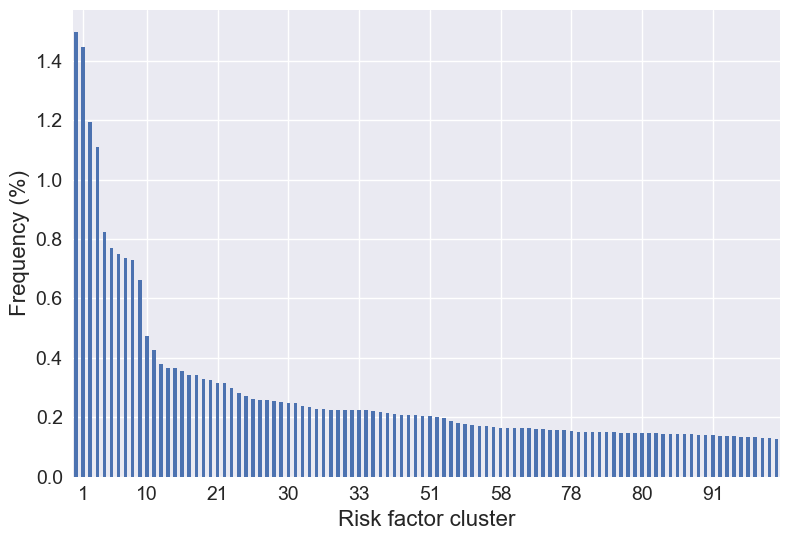

In [8]:
df3[:100].plot.bar(fontsize = 14)
plt.ylabel('Frequency (%)', fontsize = 16)
plt.xlabel('Risk factor cluster', fontsize = 16)

a = [1]
a.extend(range(10, 100, 10))
plt.xticks(a, rotation = 0);